In [1]:
import pandas as pd
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

from utils import plot_drug_gene_network_and_barplot

In [3]:
tmp = pd.read_csv("nsc_cid_smiles_class_name.csv", usecols=["NAME", "MECHANISM", "NSC"])
tmp.columns = ["nsc", "moa", "drug"]
gea = pd.read_csv("gsea_results.csv", index_col=0).merge(tmp, how="left")
gea["moa"] = gea["moa"].apply(lambda x: "Other" if x == "Acetalax" else x)
gea["moa"] = gea["moa"].fillna("Other")
gea = gea[gea["moa"] != "Other"]
gea.Term = gea.Term.replace("Pperoxisome", "Peroxisome")
gea["moa"].value_counts()

moa
Kinase         2500
DNA            1944
TUBB            313
HDAC            302
Apoptosis       186
Ho              106
PSM              92
HSP90            36
Methylation      15
BRD              10
Name: count, dtype: int64

In [4]:
df = pd.read_csv(
    "moa_with_top5.csv",
)
atten = pd.read_csv("ACs.csv.gz", index_col=0, low_memory=False)
atten.index = atten.index.astype(str)
df["atten_score"] = [atten.loc[str(i), j] for i, j in zip(df["NSC"], df["gene"])]
df.head()

,Unnamed: 0,NSC,drug,gene,num,rank,dti_existed,predicted_positive,drug_gene,pubmed_hit,top5,key,MECHANISM,atten_score
0,0,740,Methotrexate,TYMS,67,3,1,1,740_TYMS,True,True,740_TYMS,DNA,0.002270
1,1,740,Methotrexate,ATIC,67,1,1,1,740_ATIC,True,True,740_ATIC,DNA,0.001822
2,2,752,Thioguanine,BST2,0,5,0,0,752_BST2,False,True,752_BST2,DNA,0.001942
3,3,752,Thioguanine,APBB1IP,0,1,0,0,752_APBB1IP,False,True,752_APBB1IP,DNA,0.002651
4,4,752,Thioguanine,SLC43A3,2,3,0,1,752_SLC43A3,True,True,752_SLC43A3,DNA,0.002118


In [5]:
target_drugs = [
    "Gefitinib",
    "Vemurafenib",
    "Nilotinib",
    "Dovitinib",
    "Erlotinib hydrochloride",
]

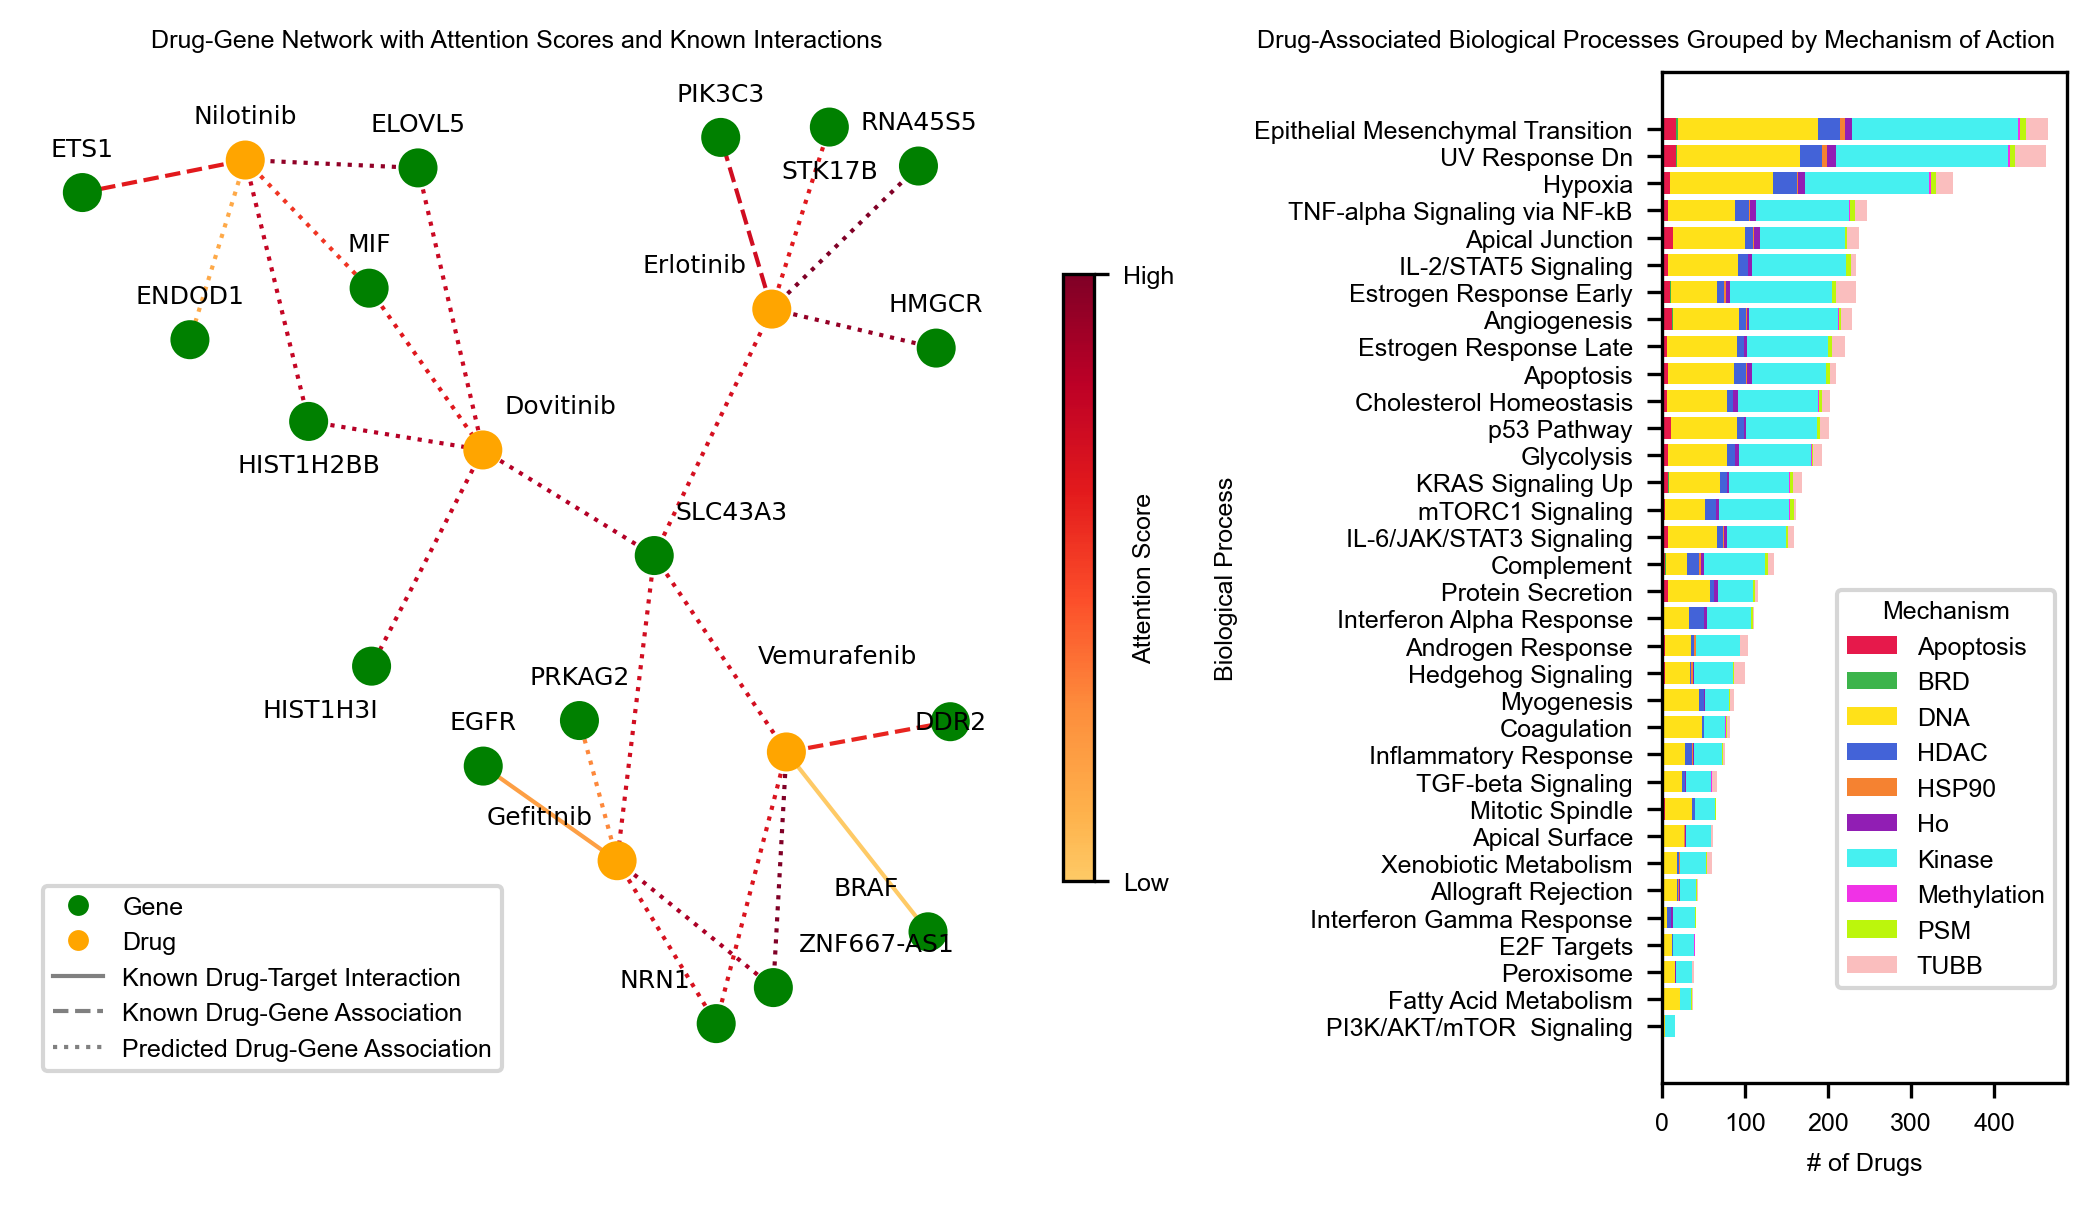

In [6]:
plot_drug_gene_network_and_barplot(df, target_drugs, gea)

In [7]:
target_drugs = [
    "Topotecan",
    "Camptothecin",
    "Irinotecan",
    "Adriblastin",
    "Daunorubicin",
]

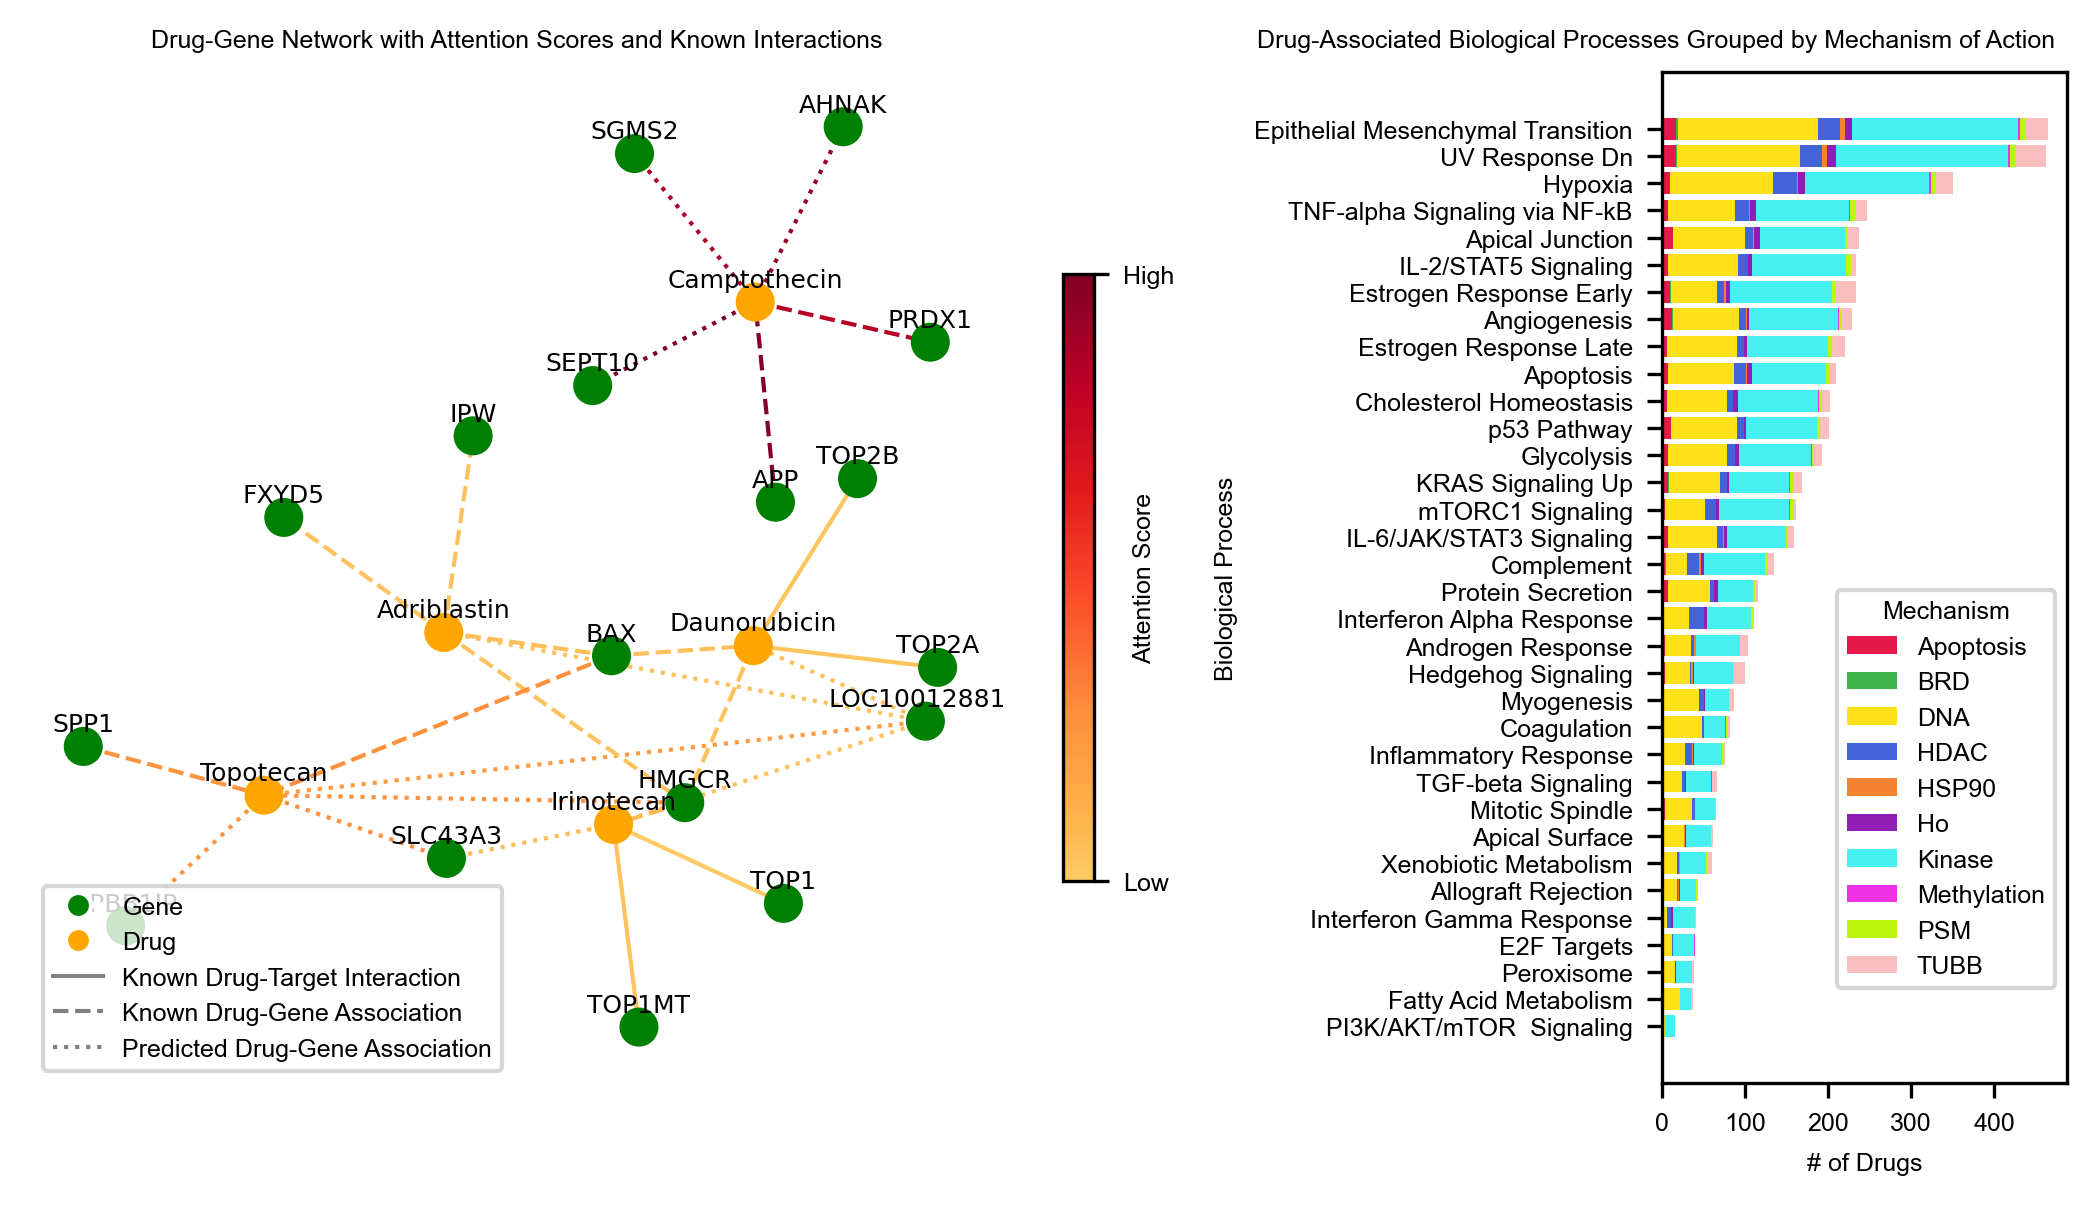

In [8]:
plot_drug_gene_network_and_barplot(df, target_drugs, gea)